# S&P 500 Trading Algorithm

This notebook implements a trading algorithm for the S&P 500 using machine learning models. We will use available parameters as signals and build models like FFNN, LSTM, and CNN.

## Data Loading and Exploration

In [16]:
import pandas as pd
import numpy as np


# Load the CSV data
data = pd.read_csv("C:/Users/David/Documents/GitHub/Quantitative_Trading_Algorithm/output.csv")

# Print the columns to understand the data structure
print("Data Columns:")
print(data.columns)

# Based on the legend, we should map these columns to lowercase
selected_columns = [
    'emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr',
    'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un',
    'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf',
    '_au', '_dxy', '_lcp', '_ty', '_oil',
    '_mkt', '_va', '_gr'
]

# Check if the selected columns are in the data
available_columns = [col for col in selected_columns if col in data.columns]
print("Selected Available Columns:")
print(available_columns)

# Extracting the relevant columns
data = data[available_columns + ['snp']]  # Including 'snp' as target

Data Columns:
Index(['emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr', 'y02', 'y10',
       'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss',
       'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr',
       'snp', 'date', 'year', 'month', 'day', 'label'],
      dtype='object')
Selected Available Columns:
['emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr', 'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr']


## Preprocess and Feature Engineering

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Handle missing values
data = data.dropna()

# Extract features and target
features = data.drop(columns=['snp'])
target = data['snp']

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

print("Feature Engineering and Data Preprocessing Complete.")


Feature Engineering and Data Preprocessing Complete.


## Custom Train-Test Split for LSTM To Keep Data Sequential

In [18]:
# Custom function to split data for each year to keep the data sequential
def custom_train_test_split(features, target, train_size=42, test_size=10):
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
    for start in range(0, len(features), train_size + test_size):
        end_train = start + train_size
        end_test = end_train + test_size
        if end_test <= len(features):
            X_train_list.append(features[start:end_train])
            y_train_list.append(target[start:end_train])
            X_test_list.append(features[end_train:end_test])
            y_test_list.append(target[end_train:end_test])
    
    X_train_lstm_prepared = np.concatenate(X_train_list)
    y_train_lstm_prepared = np.concatenate(y_train_list)
    X_test_lstm_prepared = np.concatenate(X_test_list)
    y_test_lstm_prepared = np.concatenate(y_test_list)
    
    return X_train_lstm_prepared, y_train_lstm_prepared, X_test_lstm_prepared, y_test_lstm_prepared

# Split the data using the custom function
X_train_lstm_prepared, y_train_lstm_prepared, X_test_lstm_prepared, y_test_lstm_prepared = custom_train_test_split(features_scaled, target)

# Reshape data for LSTM (needs 3D input)
X_train_lstm = X_train_lstm_prepared.reshape((X_train_lstm_prepared.shape[0], 1, X_train_lstm_prepared.shape[1]))
X_test_lstm = X_test_lstm_prepared.reshape((X_test_lstm_prepared.shape[0], 1, X_test_lstm_prepared.shape[1]))


## Model Implementation

### Feed-Forward Neural Network (FFNN)

Epoch 1/50


C:\Users\David\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3737322.0000 - val_loss: 3798743.7500
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3736310.7500 - val_loss: 3393357.2500
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3085424.7500 - val_loss: 2328801.7500
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1957815.2500 - val_loss: 958843.7500
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 848307.2500 - val_loss: 273527.2500
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 314557.9688 - val_loss: 143072.7344
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 203013.2188 - val_loss: 104858.0391
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181113.2344 - val_loss: 82291.1094
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 154343.7969 - val_loss: 67517.1484
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 124147.1328 - val_loss: 56533.1250
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123557.

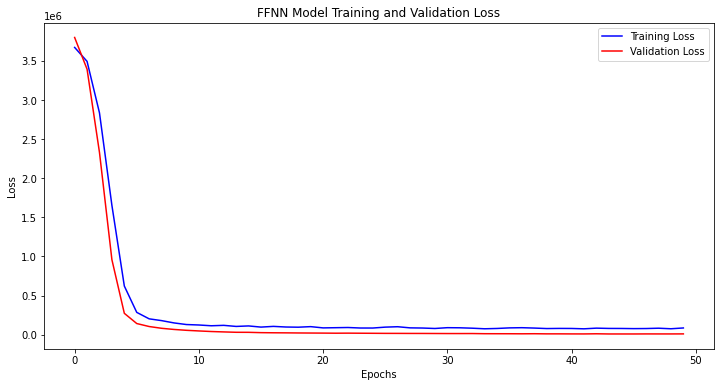

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the FFNN model creation function
def create_ffnn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Training with all parameters
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ffnn_model = create_ffnn_model(X_train_scaled.shape[1])
ffnn_history = ffnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation = ffnn_model.evaluate(X_test_scaled, y_test)
print(f"FFNN Model Test Loss: {ffnn_evaluation}")

ffnn_predictions = ffnn_model.predict(X_test_scaled)
print("FFNN Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(ffnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(ffnn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('FFNN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Long Short-Term Memory Network (LSTM)

Epoch 1/40


C:\Users\David\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1375816.7500 - val_loss: 12299986.0000
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1391320.2500 - val_loss: 12291557.0000
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1370674.8750 - val_loss: 12272723.0000
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1352257.5000 - val_loss: 12234083.0000
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1335338.5000 - val_loss: 12157497.0000
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1382262.2500 - val_loss: 12019376.0000
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1360055.5000 - val_loss: 11792779.0000
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1258678.1250 - val_loss: 11490935.0000
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1273446.2500 - val_loss: 11072894.0000
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1254834.6250 - val_loss: 10563922.0000
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 

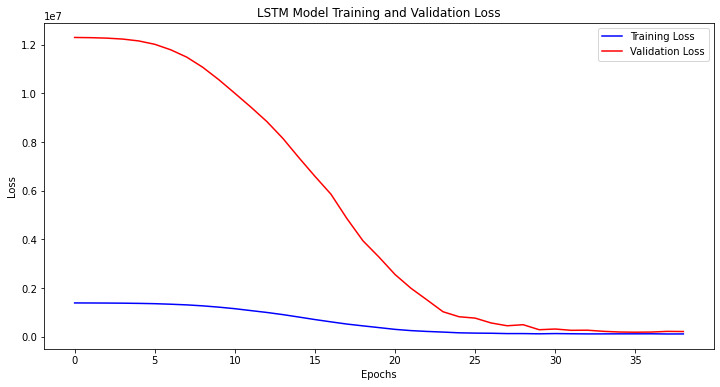

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define the LSTM model creation function
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(10, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(BatchNormalization())  # Add batch normalization
    model.add(Dense(32, activation='relu'))  # Add an additional dense layer
    model.add(Dropout(0.5))  # Add another dropout for regularization
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
lstm_model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lstm_history = lstm_model.fit(X_train_lstm, y_train_lstm_prepared, epochs=40, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])

lstm_evaluation = lstm_model.evaluate(X_test_lstm, y_test_lstm_prepared)
print(f"LSTM Model Test Loss: {lstm_evaluation}")

lstm_predictions = lstm_model.predict(X_test_lstm)
print("LSTM Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Convolutional Neural Network (CNN)

Epoch 1/40


C:\Users\David\anaconda3\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3427085.7500 - val_loss: 1146521.1250
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1100911.8750 - val_loss: 846225.6250
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 818507.7500 - val_loss: 356486.3125
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 269870.0000 - val_loss: 129523.1484
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 133429.5156 - val_loss: 82490.4531
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 86778.9062 - val_loss: 61944.7422
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 64584.1758 - val_loss: 44326.8750
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 46050.1250 - val_loss: 35527.8477
Epoch 9/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 39150.0508 - val_loss: 30290.4141
Epoch 10/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30101.1523 - val_loss: 27175.0098
Epoch 11/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30537.7969 - val_lo

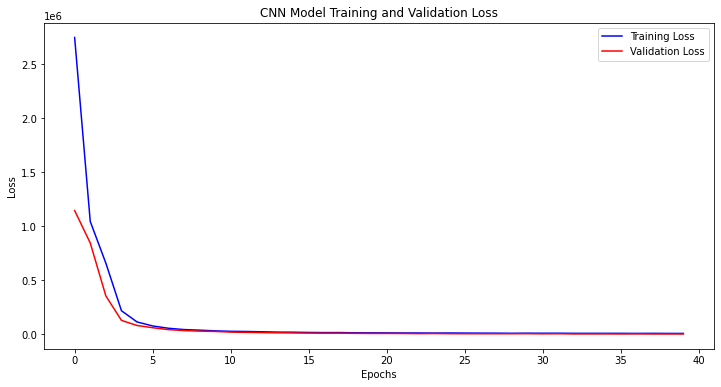

In [21]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Define the CNN model creation function
def create_cnn_model(input_dim):
    model = Sequential()
    model.add(Reshape((input_dim, 1), input_shape=(input_dim,)))
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.25))  # Dropout layer to reduce overfitting
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

cnn_model = create_cnn_model(X_train_scaled.shape[1])
cnn_history = cnn_model.fit(X_train_scaled, y_train, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

cnn_evaluation = cnn_model.evaluate(X_test_scaled, y_test)
print(f"CNN Model Test Loss: {cnn_evaluation}")

cnn_predictions = cnn_model.predict(X_test_scaled)
print("CNN Model Training and Evaluation Complete.")

plt.figure(figsize=(12, 6))
plt.plot(cnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('CNN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#
From here trash code

Dave Evaluation of Strategy:
- [ ] Sharpe Ratio -> Verschoben auf nach Strategie Implementation
- [x] In sample, out sample performance
- [x] Information Coefficient


Rafael
- [ ] Use Multiple Sets of Signals

Felix
- [ ] Write shit
- [ ] Hyperparameter Tuning (Optional)

After:
- [ ] Hyperparameter Tuning
- [ ] Data Augmentation


## Backtest and Evaluate the Models

Get the in-sample and out-of-sample R-Squared and MSE


In [22]:
from sklearn.metrics import mean_squared_error, r2_score

# In sample predictions
ffnn_train_predictions = ffnn_model.predict(X_train)
lstm_train_predictions = lstm_model.predict(X_train_lstm)
cnn_train_predictions = cnn_model.predict(X_train)

# FFNN performance
ffnn_in_sample_r2 = r2_score(y_train, ffnn_train_predictions)
ffnn_out_sample_r2 = r2_score(y_test, ffnn_predictions)
ffnn_in_sample_mse = mean_squared_error(y_train, ffnn_train_predictions)
ffnn_out_sample_mse = mean_squared_error(y_test, ffnn_predictions)

# LSTM performance
lstm_in_sample_r2 = r2_score(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_r2 = r2_score(y_test_lstm_prepared, lstm_predictions)
lstm_in_sample_mse = mean_squared_error(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_mse = mean_squared_error(y_test_lstm_prepared, lstm_predictions)

# CNN performance
cnn_in_sample_r2 = r2_score(y_train, cnn_train_predictions)
cnn_out_sample_r2 = r2_score(y_test, cnn_predictions)
cnn_in_sample_mse = mean_squared_error(y_train, cnn_train_predictions)
cnn_out_sample_mse = mean_squared_error(y_test, cnn_predictions)

print(f"FFNN In-sample R-squared: {ffnn_in_sample_r2}")
print(f"FFNN In-sample MSE: {ffnn_in_sample_mse}")
print(f"FFNN Out-sample R-squared: {ffnn_out_sample_r2}")
print(f"FFNN Out-sample MSE: {ffnn_out_sample_mse}")
print("---------------------------------------------------")
print(f"LSTM In-sample R-squared: {lstm_in_sample_r2}")
print(f"LSTM In-sample MSE: {lstm_in_sample_mse}")
print(f"LSTM Out-sample R-squared: {lstm_out_sample_r2}")
print(f"LSTM Out-sample MSE: {lstm_out_sample_mse}")
print("---------------------------------------------------")
print(f"CNN In-sample R-squared: {cnn_in_sample_r2}")
print(f"CNN In-sample MSE: {cnn_in_sample_mse}")
print(f"CNN Out-sample R-squared: {cnn_out_sample_r2}")
print(f"CNN Out-sample MSE: {cnn_out_sample_mse}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
FFNN In-sample R-squared: 0.9886123508017652
FFNN In-sample MSE: 14793.776358166922
FFNN Out-sample R-squared: 0.988107949850151
FFNN Out-sample MSE: 17624.963688255946
---------------------------------------------------
LSTM In-sample R-squared: 0.9541005414121448
LSTM In-sample MSE: 56305.1596693485
LSTM Out-sample R-squared: 0.9651529313863888
LSTM Out-sample MSE: 49951.57161086059
---------------------------------------------------
CNN In-sample R-squared: -3.650362137973116
CNN In-sample MSE: 6041318.647603355
CNN Out-sample R-squared: 0.9953929776564018
CNN Out-sample MSE: 6827.97335141865


The Information Coefficient (IC) measures the correlation between predicted and actual returns.
see: https://www.investopedia.com/terms/i/information-coefficient.asp

In [23]:
import numpy as np

def calculate_proportion_correct(predictions, actuals):
    # Flatten the arrays to 1D
    predictions = predictions.flatten()
    actuals = actuals.flatten()
    
    # Align the lengths by trimming the last element of both arrays if one is longer than the other
    min_length = min(len(predictions), len(actuals))
    predictions = predictions[:min_length]
    actuals = actuals[:min_length]
    
    # Calculate the direction of actual returns and predicted returns
    actual_directions = np.diff(actuals) > 0
    predicted_directions = np.diff(predictions) > 0
    
    # Determine the correct predictions (correct direction)
    correct_predictions = np.where(predicted_directions == actual_directions, 1, 0)
    
    # Calculate the proportion of correct predictions
    proportion_correct = np.mean(correct_predictions)
    
    return proportion_correct

def calculate_ic(proportion_correct):
    return (2 * proportion_correct) - 1

# Calculate proportion correct for FFNN
ffnn_proportion_correct = calculate_proportion_correct(ffnn_predictions, y_test.values)
ffnn_ic_new = calculate_ic(ffnn_proportion_correct)

print(f"FFNN Information Coefficient (new method): {ffnn_ic_new}")
print("---------------------------------------------------")
# Calculate proportion correct for LSTM
lstm_proportion_correct = calculate_proportion_correct(lstm_predictions, y_test_lstm_prepared)
lstm_ic_new = calculate_ic(lstm_proportion_correct)
print(f"LSTM Information Coefficient (new method): {lstm_ic_new}")
print("---------------------------------------------------")
cnn_proportion_correct = calculate_proportion_correct(cnn_predictions, y_test.values)
cnn_ic_new = calculate_ic(cnn_proportion_correct)
print(f"CNN Information Coefficient (new method): {cnn_ic_new}")


FFNN Information Coefficient (new method): 0.925531914893617
---------------------------------------------------
LSTM Information Coefficient (new method): 0.11420612813370479
---------------------------------------------------
CNN Information Coefficient (new method): 0.9308510638297873


Sharpe Ratio Calculation:
Still To Do


### Show and Discuss Results
We will create charts to visualize the actual vs. predicted values for each model and discuss the results.

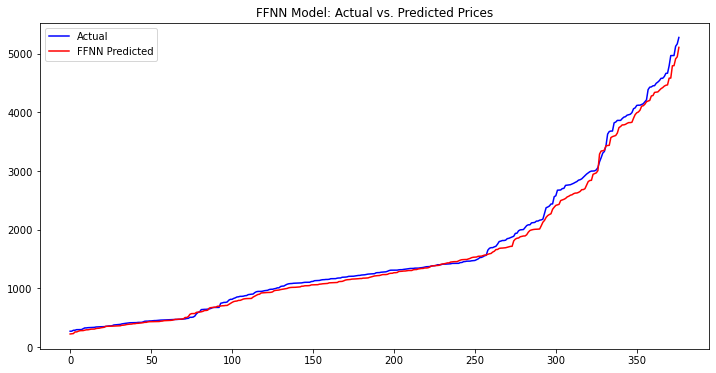

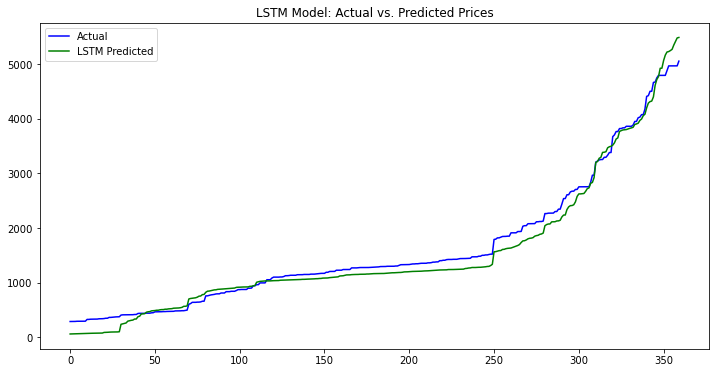

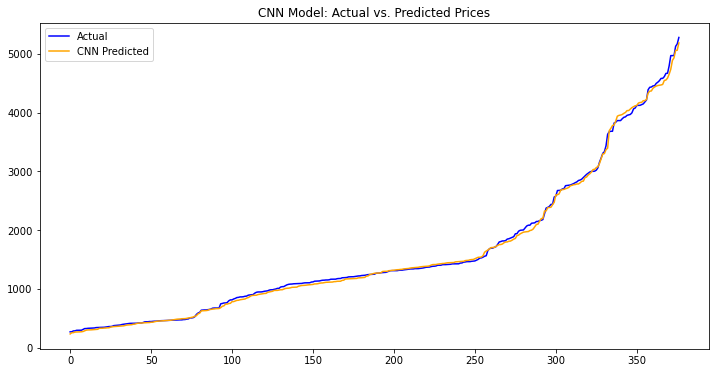

In [24]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values for FFNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_predictions.flatten()), label='FFNN Predicted', color='red')
plt.title('FFNN Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Plot actual vs. predicted values for LSTM
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_lstm_prepared), label='Actual', color='blue')
plt.plot(sorted(lstm_predictions.flatten()), label='LSTM Predicted', color='green')
plt.title('LSTM Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Plot actual vs. predicted values for CNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(cnn_predictions.flatten()), label='CNN Predicted', color='orange')
plt.title('CNN Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()


# DAVE TILL HERE

# RAFAEL FROM HERE

### Step 3: Use Multiple Sets of Signals
We will evaluate the models using two sets of signals:

Set 1: Macroeconomic Signals:

GDP: Gross Domestic Product growth.
CPI: Inflation rate.
UN: Unemployment rate.
IR: Nominal interest rate.
Y10: 10Y treasury yield.
Economic Motivation: These indicators are fundamental to the overall economic environment and can significantly influence stock market movements. Changes in GDP, inflation, and interest rates are closely monitored by investors.

Set 2: Market and Technical Signals:

PE: Price/Earnings ratio.
DY: Dividend yield.
_MKT: Market returns.
_VA: Value index.
_GR: Growth index.
Economic Motivation: These indicators provide insight into market valuation and performance. They help understand the relative attractiveness of stocks and the broader market trends.

We will re-train and evaluate the models using these sets of signals.

## FFNN

Epoch 1/40


C:\Users\David\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3478391.7500 - val_loss: 3820044.5000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3696504.2500 - val_loss: 3755008.5000
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3733211.5000 - val_loss: 3542344.2500
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3505498.0000 - val_loss: 3133119.0000
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3189142.0000 - val_loss: 2595740.7500
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2480006.0000 - val_loss: 2119183.0000
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2074760.0000 - val_loss: 1806669.8750
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1825073.2500 - val_loss: 1658232.8750
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1677911.5000 - val_loss: 1573234.7500
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1547910.2500 - val_loss: 1509606.2500
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

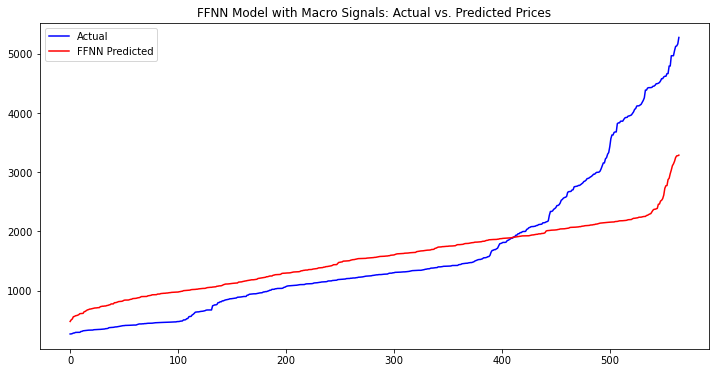

Epoch 1/40


C:\Users\David\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3593077.5000 - val_loss: 3816998.0000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3602988.7500 - val_loss: 3732939.5000
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3552537.0000 - val_loss: 3479838.0000
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3027864.0000 - val_loss: 3001824.2500
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2566444.0000 - val_loss: 2328365.2500
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1986268.1250 - val_loss: 1595721.0000
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1446838.3750 - val_loss: 997322.3125
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 980742.0625 - val_loss: 641816.3125
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 591762.2500 - val_loss: 464406.9062
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 562342.2500 - val_loss: 378541.8750
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

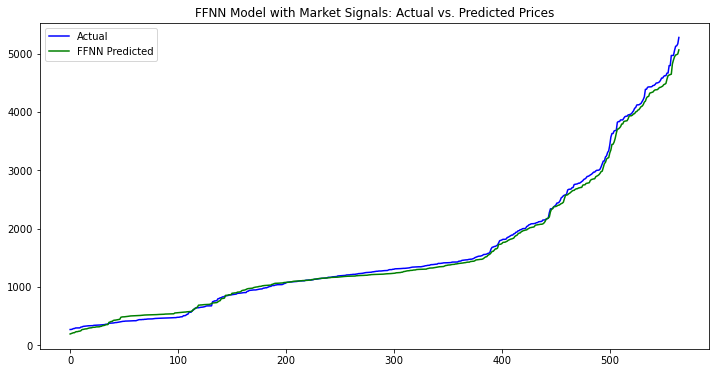

In [25]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)

ffnn_model_macro = create_ffnn_model(X_train_macro.shape[1])
ffnn_history_macro = ffnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation_macro = ffnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"FFNN Model with Macro Signals Test Loss: {ffnn_evaluation_macro}")

ffnn_macro_predictions = ffnn_model_macro.predict(X_test_macro)
ffnn_macro_mse = mean_squared_error(sorted(y_test_macro), ffnn_macro_predictions)
ffnn_macro_r2 = r2_score(sorted(y_test_macro), ffnn_macro_predictions)
print(f"FFNN with Macro Signals MSE: {ffnn_macro_mse}")
print(f"FFNN with Macro Signals R-squared: {ffnn_macro_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_macro.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_macro_predictions.flatten()), label='FFNN Predicted', color='red')
plt.title('FFNN Model with Macro Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)

ffnn_model_market = create_ffnn_model(X_train_market.shape[1])
ffnn_history_market = ffnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation_market = ffnn_model_market.evaluate(X_test_market, y_test_market)
print(f"FFNN Model with Market Signals Test Loss: {ffnn_evaluation_market}")

ffnn_market_predictions = ffnn_model_market.predict(X_test_market)
ffnn_market_mse = mean_squared_error(sorted(y_test_market), ffnn_market_predictions)
ffnn_market_r2 = r2_score(sorted(y_test_market), ffnn_market_predictions)
print(f"FFNN with Market Signals MSE: {ffnn_market_mse}")
print(f"FFNN with Market Signals R-squared: {ffnn_market_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_market.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_market_predictions.flatten()), label='FFNN Predicted', color='green')
plt.title('FFNN Model with Market Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# LSTM

Epoch 1/100


C:\Users\David\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1391063.8750 - val_loss: 12304016.0000
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1461433.1250 - val_loss: 12301821.0000
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1419897.8750 - val_loss: 12297640.0000
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1344743.2500 - val_loss: 12289729.0000
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1324584.1250 - val_loss: 12274657.0000
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1419387.6250 - val_loss: 12249174.0000
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1356165.3750 - val_loss: 12207753.0000
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1371365.3750 - val_loss: 12145653.0000
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1333164.5000 - val_loss: 12061917.0000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1309935.1250 - val_loss: 11948029.0000
Epoch 11/100
38/38 ━━━━━━━━━━━

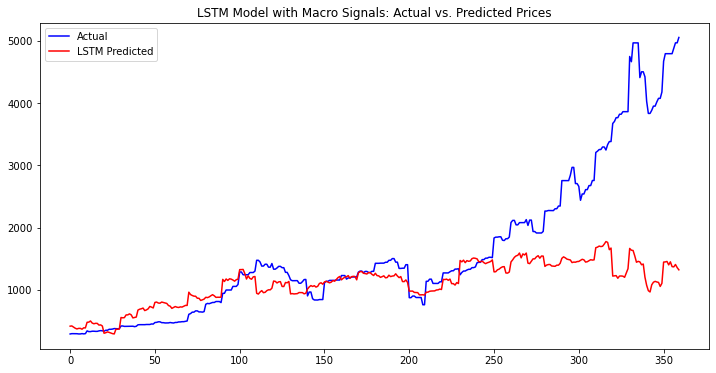

Epoch 1/100


C:\Users\David\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 1384053.7500 - val_loss: 12303345.0000
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1350807.8750 - val_loss: 12299455.0000
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1488672.3750 - val_loss: 12291382.0000
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1408041.5000 - val_loss: 12276249.0000
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1375543.8750 - val_loss: 12245205.0000
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1328747.3750 - val_loss: 12190854.0000
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1330719.0000 - val_loss: 12101434.0000
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1329942.0000 - val_loss: 11950454.0000
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1350134.6250 - val_loss: 11714345.0000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1235517.1250 - val_loss: 11392478.0000
Epoch 11/100
38/38 ━━━━━━━━━━━

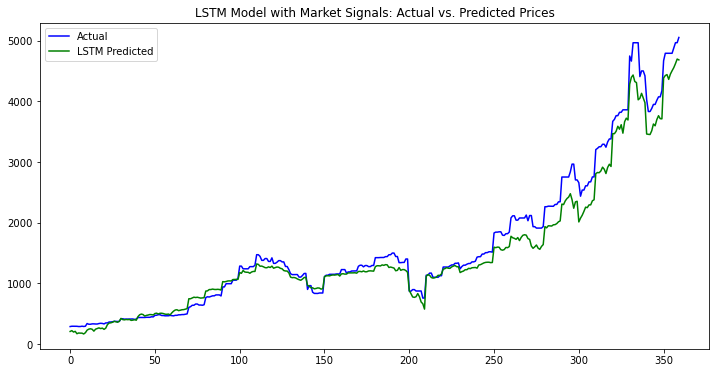

In [26]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter and reshape data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

# Split the data using the custom function
X_train_macro_prepared, y_train_macro_prepared, X_test_macro_prepared, y_test_macro_prepared = custom_train_test_split(features_macro_scaled, target_macro)

# Reshape data for LSTM (needs 3D input)
X_train_macro_lstm = X_train_macro_prepared.reshape((X_train_macro_prepared.shape[0], 1, X_train_macro_prepared.shape[1]))
X_test_macro_lstm = X_test_macro_prepared.reshape((X_test_macro_prepared.shape[0], 1, X_test_macro_prepared.shape[1]))

lstm_model_macro = create_lstm_model((X_train_macro_lstm.shape[1], X_train_macro_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Increased patience
lstm_history_macro = lstm_model_macro.fit(X_train_macro_lstm, y_train_macro_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_macro = lstm_model_macro.evaluate(X_test_macro_lstm, y_test_macro_prepared)
print(f"LSTM Model with Macro Signals Test Loss: {lstm_evaluation_macro}")

lstm_macro_predictions = lstm_model_macro.predict(X_test_macro_lstm)
lstm_macro_mse = mean_squared_error(y_test_macro_prepared, lstm_macro_predictions)
lstm_macro_r2 = r2_score(y_test_macro_prepared, lstm_macro_predictions)
print(f"LSTM with Macro Signals MSE: {lstm_macro_mse}")
print(f"LSTM with Macro Signals R-squared: {lstm_macro_r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_macro_prepared, label='Actual', color='blue')
plt.plot(lstm_macro_predictions.flatten(), label='LSTM Predicted', color='red')
plt.title('LSTM Model with Macro Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter and reshape data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

# Split the data using the custom function
X_train_market_prepared, y_train_market_prepared, X_test_market_prepared, y_test_market_prepared = custom_train_test_split(features_market_scaled, target_market)

# Reshape data for LSTM (needs 3D input)
X_train_market_lstm = X_train_market_prepared.reshape((X_train_market_prepared.shape[0], 1, X_train_market_prepared.shape[1]))
X_test_market_lstm = X_test_market_prepared.reshape((X_test_market_prepared.shape[0], 1, X_test_market_prepared.shape[1]))

lstm_model_market = create_lstm_model((X_train_market_lstm.shape[1], X_train_market_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Increased patience
lstm_history_market = lstm_model_market.fit(X_train_market_lstm, y_train_market_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_market = lstm_model_market.evaluate(X_test_market_lstm, y_test_market_prepared)
print(f"LSTM Model with Market Signals Test Loss: {lstm_evaluation_market}")

lstm_market_predictions = lstm_model_market.predict(X_test_market_lstm)
lstm_market_mse = mean_squared_error(y_test_market_prepared, lstm_market_predictions)
lstm_market_r2 = r2_score(y_test_market_prepared, lstm_market_predictions)
print(f"LSTM with Market Signals MSE: {lstm_market_mse}")
print(f"LSTM with Market Signals R-squared: {lstm_market_r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_market_prepared, label='Actual', color='blue')
plt.plot(lstm_market_predictions.flatten(), label='LSTM Predicted', color='green')
plt.title('LSTM Model with Market Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# CNN

Epoch 1/40


C:\Users\David\anaconda3\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 3620019.2500 - val_loss: 3504695.2500
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2687456.7500 - val_loss: 1417311.5000
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1510556.5000 - val_loss: 1369384.7500
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1497170.0000 - val_loss: 1301654.7500
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1395646.8750 - val_loss: 1260153.3750
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1500711.8750 - val_loss: 1230753.8750
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1373701.1250 - val_loss: 1228798.6250
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1305782.6250 - val_loss: 1176416.0000
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1216792.7500 - val_loss: 1152338.0000
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1205057.6250 - val_loss: 1120300.6250
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

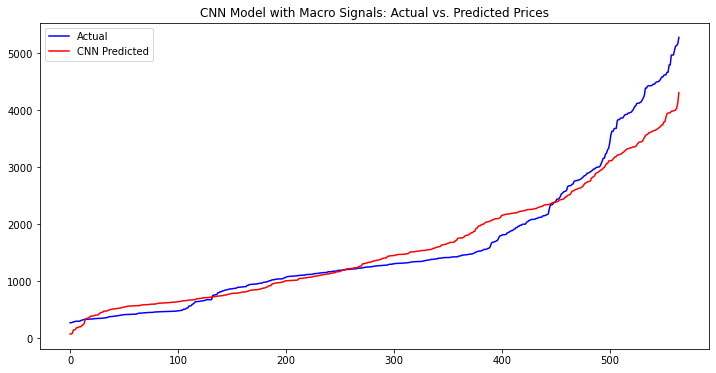

Epoch 1/40


C:\Users\David\anaconda3\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3592704.2500 - val_loss: 3354338.7500
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2555780.5000 - val_loss: 647704.7500
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 710325.7500 - val_loss: 426106.6875
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 447687.0312 - val_loss: 211016.1094
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 194603.1875 - val_loss: 74504.9688
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 75457.9688 - val_loss: 28316.6621
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 34515.5000 - val_loss: 21180.7031
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27569.8945 - val_loss: 19281.5664
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26775.5586 - val_loss: 14564.8105
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20980.6445 - val_loss: 12455.2305
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20240.1836 - val_lo

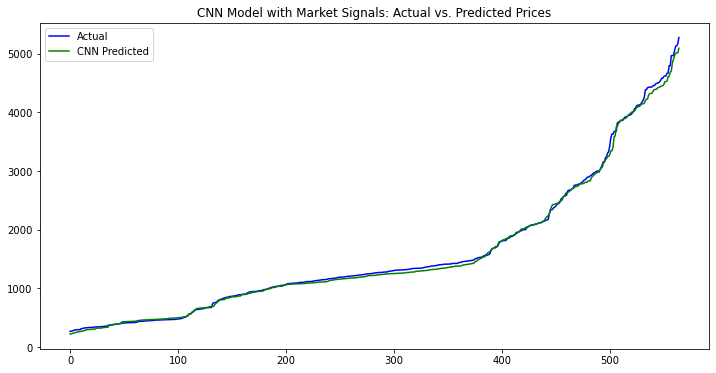

In [27]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)

cnn_model_macro = create_cnn_model(X_train_macro.shape[1])
cnn_history_macro = cnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

cnn_evaluation_macro = cnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"CNN Model with Macro Signals Test Loss: {cnn_evaluation_macro}")

cnn_macro_predictions = cnn_model_macro.predict(X_test_macro)
cnn_macro_mse = mean_squared_error(sorted(y_test_macro), cnn_macro_predictions)
cnn_macro_r2 = r2_score(sorted(y_test_macro), cnn_macro_predictions)
print(f"CNN with Macro Signals MSE: {cnn_macro_mse}")
print(f"CNN with Macro Signals R-squared: {cnn_macro_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_macro.values), label='Actual', color='blue')
plt.plot(sorted(cnn_macro_predictions.flatten()), label='CNN Predicted', color='red')
plt.title('CNN Model with Macro Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)

cnn_model_market = create_cnn_model(X_train_market.shape[1])
cnn_history_market = cnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

cnn_evaluation_market = cnn_model_market.evaluate(X_test_market, y_test_market)
print(f"CNN Model with Market Signals Test Loss: {cnn_evaluation_market}")

cnn_market_predictions = cnn_model_market.predict(X_test_market)
cnn_market_mse = mean_squared_error(sorted(y_test_market), cnn_market_predictions)
cnn_market_r2 = r2_score(sorted(y_test_market), cnn_market_predictions)
print(f"CNN with Market Signals MSE: {cnn_market_mse}")
print(f"CNN with Market Signals R-squared: {cnn_market_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_market.values), label='Actual', color='blue')
plt.plot(sorted(cnn_market_predictions.flatten()), label='CNN Predicted', color='green')
plt.title('CNN Model with Market Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# DAVE AB HIER WIEDER

### Step 4: In-sample and Out-of-sample Performance
In-sample Predictions and Plotting:

Evaluate the in-sample performance using training data.
Compare the in-sample predictions to the actual values.
Plot the actual vs. predicted values for in-sample data.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FFNN In-sample MSE: 6343.592286272416
FFNN In-sample R-squared: 0.9951169598712489


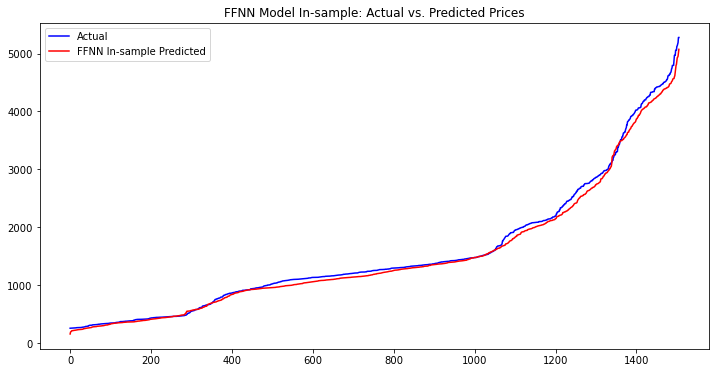

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
LSTM In-sample MSE: 32249.979728585113
LSTM In-sample R-squared: 0.9737101072494216


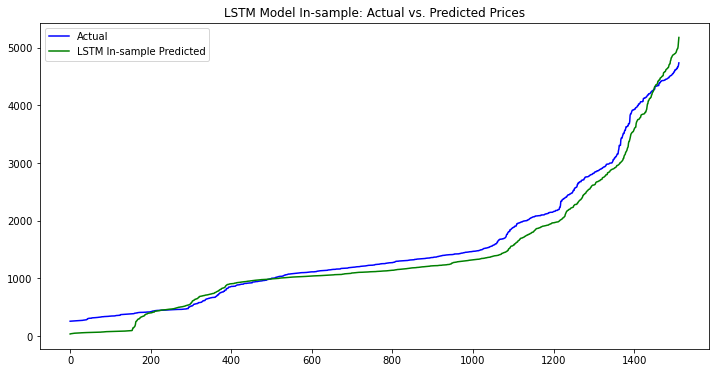

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CNN In-sample MSE: 5953445.146028727
CNN In-sample R-squared: -3.582720679462086


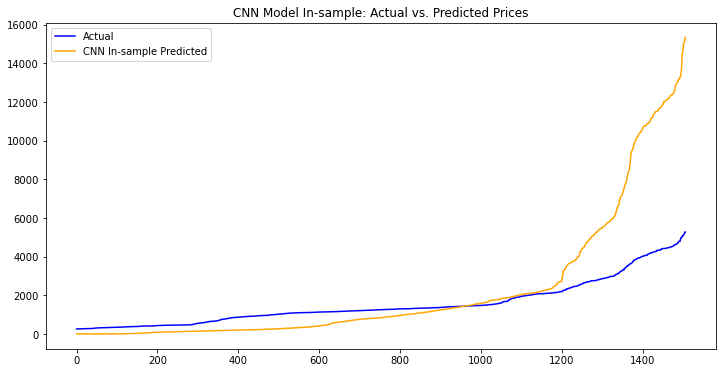

In [28]:
# In-sample predictions for FFNN
ffnn_in_sample_predictions = ffnn_model.predict(X_train)
ffnn_in_sample_mse = mean_squared_error(sorted(y_train), sorted(ffnn_in_sample_predictions))
ffnn_in_sample_r2 = r2_score(sorted(y_train), sorted(ffnn_in_sample_predictions))
print(f"FFNN In-sample MSE: {ffnn_in_sample_mse}")
print(f"FFNN In-sample R-squared: {ffnn_in_sample_r2}")

# Plot actual vs. predicted values for in-sample data (FFNN)
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_train.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_in_sample_predictions.flatten()), label='FFNN In-sample Predicted', color='red')
plt.title('FFNN Model In-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# In-sample predictions for LSTM
lstm_in_sample_predictions = lstm_model.predict(X_train_lstm)
lstm_in_sample_mse = mean_squared_error(sorted(y_train_lstm_prepared), sorted(lstm_in_sample_predictions))
lstm_in_sample_r2 = r2_score(sorted(y_train_lstm_prepared), sorted(lstm_in_sample_predictions))
print(f"LSTM In-sample MSE: {lstm_in_sample_mse}")
print(f"LSTM In-sample R-squared: {lstm_in_sample_r2}")

# Plot actual vs. predicted values for in-sample data (LSTM)
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_train_lstm_prepared), label='Actual', color='blue')
plt.plot(sorted(lstm_in_sample_predictions.flatten()), label='LSTM In-sample Predicted', color='green')
plt.title('LSTM Model In-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# In-sample predictions for CNN
cnn_in_sample_predictions = cnn_model.predict(X_train)
cnn_in_sample_mse = mean_squared_error(sorted(y_train), sorted(cnn_in_sample_predictions))
cnn_in_sample_r2 = r2_score(sorted(y_train), sorted(cnn_in_sample_predictions))
print(f"CNN In-sample MSE: {cnn_in_sample_mse}")
print(f"CNN In-sample R-squared: {cnn_in_sample_r2}")

# Plot actual vs. predicted values for in-sample data (CNN)
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_train.values), label='Actual', color='blue')
plt.plot(sorted(cnn_in_sample_predictions.flatten()), label='CNN In-sample Predicted', color='orange')
plt.title('CNN Model In-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()


Out-of-sample Predictions and Plotting:

Evaluate the out-of-sample performance using testing data (already calculated).
Compare the out-of-sample predictions to the actual values.
Plot the actual vs. predicted values for out-of-sample data.

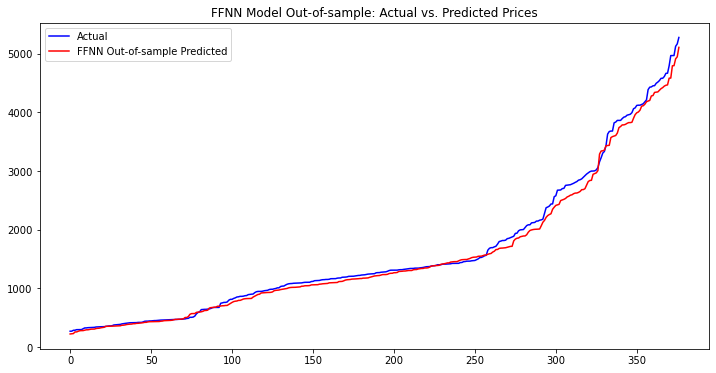

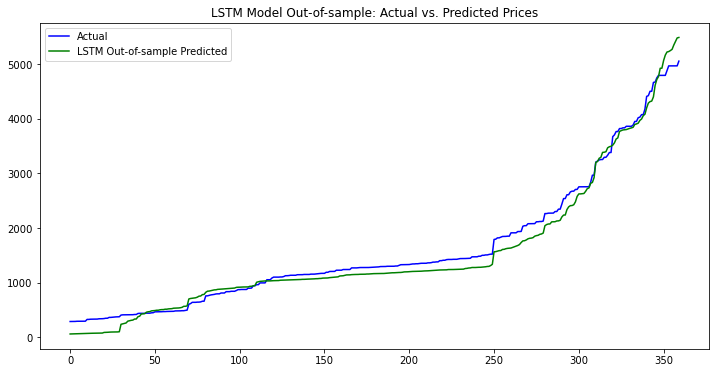

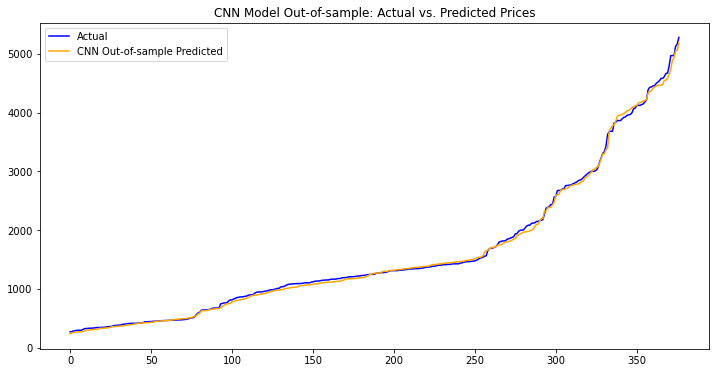

In [29]:
# Out-of-sample predictions for FFNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_predictions.flatten()), label='FFNN Out-of-sample Predicted', color='red')
plt.title('FFNN Model Out-of-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Out-of-sample predictions for LSTM
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_lstm_prepared), label='Actual', color='blue')
plt.plot(sorted(lstm_predictions.flatten()), label='LSTM Out-of-sample Predicted', color='green')
plt.title('LSTM Model Out-of-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Out-of-sample predictions for CNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(cnn_predictions.flatten()), label='CNN Out-of-sample Predicted', color='orange')
plt.title('CNN Model Out-of-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

### Step 5: Analyze Hypotheses and Results
We will form hypotheses based on our two sets of signals and compare the results to these expectations.

Hypotheses:

Macroeconomic Signals:

Hypothesis: Macroeconomic indicators such as GDP, CPI, and interest rates significantly influence the S&P 500 movements, and models using these signals will have strong predictive power.
Expected Results: Higher R-squared values and lower MSE for models trained with macroeconomic signals compared to other signals.
Market and Technical Signals:

Hypothesis: Market and technical indicators, such as P/E ratio, dividend yield, and market returns, provide a closer insight into stock market valuation and performance. These signals should lead to better short-term predictive performance.
Expected Results: More accurate short-term predictions reflected in tighter alignment of actual vs. predicted values.
Evaluate and Discuss Results:

Compare the in-sample and out-of-sample performance of models using different sets of signals.
Discuss whether the results support the initial hypotheses.

In [30]:
# Evaluate FFNN with macro signals
ffnn_macro_predictions = ffnn_model_macro.predict(X_test_macro)
ffnn_macro_mse = mean_squared_error(y_test_macro, ffnn_macro_predictions)
ffnn_macro_r2 = r2_score(y_test_macro, ffnn_macro_predictions)
print(f"FFNN with Macro Signals MSE: {ffnn_macro_mse}")
print(f"FFNN with Macro Signals R-squared: {ffnn_macro_r2}")

# Evaluate FFNN with market signals
ffnn_market_predictions = ffnn_model_market.predict(X_test_market)
ffnn_market_mse = mean_squared_error(y_test_market, ffnn_market_predictions)
ffnn_market_r2 = r2_score(y_test_market, ffnn_market_predictions)
print(f"FFNN with Market Signals MSE: {ffnn_market_mse}")
print(f"FFNN with Market Signals R-squared: {ffnn_market_r2}")

# Compare in-sample and out-of-sample performance
print(f"In-sample R-squared: {ffnn_in_sample_r2}")
print(f"Out-of-sample R-squared: {ffnn_r2}")

# Discuss whether the results support the initial hypotheses
if ffnn_macro_r2 > ffnn_market_r2:
    print("Macroeconomic signals provided better predictive power.")
else:
    print("Market and technical signals provided better predictive power.")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
FFNN with Macro Signals MSE: 810113.4707690213
FFNN with Macro Signals R-squared: 0.4301940220733016
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
FFNN with Market Signals MSE: 12412.380618643208
FFNN with Market Signals R-squared: 0.9912695579915607
In-sample R-squared: 0.9951169598712489


NameError: name 'ffnn_r2' is not defined

### Summary
Calculated Model Accuracy: We used MSE and R-squared to evaluate model performance.
Visualized Results: Plotted actual vs. predicted values for both in-sample and out-of-sample data.
Used Multiple Signal Sets: Evaluated models with macroeconomic and market/technical signals, providing economic motivation.
Analyzed Hypotheses: Formulated and tested hypotheses based on signal sets and discussed the results.
This comprehensive approach ensures we have a detailed analysis and understanding of the performance of our trading algorithm. If you need any further details or additional steps, please let me know!